# 8.3

# (a):LDA

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [28]:
data=np.load("./data/mnist-data-hw3.npz")
data.keys()

KeysView(NpzFile './data/mnist-data-hw3.npz' with keys: training_data, training_labels, test_data)

In [29]:
data['training_data'].reshape(60000,28*28)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784), dtype=uint8)

In [30]:
training_data=data['training_data']
training_label=data['training_labels']


In [31]:
training_data=training_data.reshape(60000,28*28)

In [32]:
def compute_lda_parameters(X_train,y_train,regularization=1e-3):
    n_classes=len(np.unique(y_train))
    n_features=X_train.shape[1]

    means=np.zeros((n_classes,n_features))
    for c in range(n_classes):
        class_mask=(y_train==c)
        means[c]=np.mean(X_train[class_mask],axis=0)

    pooled_cov=np.zeros((n_features,n_features))
    total_samples=len(X_train)

    for c in range(n_classes):
        class_mask=(y_train==c)
        class_data=X_train[class_mask]
        n_class_samples=len(class_data)

        if n_class_samples>1:
            centered_data=class_data-means[c]
            class_cov=np.dot(centered_data.T,centered_data)/(n_class_samples-1)

            pooled_cov+=(n_class_samples/total_samples)*class_cov

    pooled_cov+=regularization*np.eye(n_features)

    return means,pooled_cov

In [33]:
def lda_predict(X,means,pooled_cov,prior_probs):
    n_samples,n_features=X.shape
    n_classes=len(means)

    try:
        inv_cov=np.linalg.inv(pooled_cov)
    except np.linalg.LinAlgError:
        reg_cov=pooled_cov+1e-6*np.eye(n_features)
        inv_cov=np.linalg.inv(reg_cov)

    log_posterior=np.zeros((n_samples,n_classes))

    for c in range(n_classes):
        linear_term=np.dot(X,np.dot(inv_cov,means[c]))
        constant_term=-0.5*np.dot(means[c],np.dot(inv_cov,means[c]))
        log_posterior[:,c]=linear_term+constant_term+np.log(prior_probs[c])


    return np.argmax(log_posterior,axis=1)



In [34]:
def split_data(X,y,test_size=10000,random_state=42):
    np.random.seed(random_state)
    n_samples=len(X)
    indices=np.random.permutation(n_samples)

    train_indices=indices[test_size:]
    val_indices=indices[:test_size]

    return X[train_indices],X[val_indices],y[train_indices],y[val_indices]

In [35]:
def experiment_lda_sizes(X_train, y_train, X_val, y_val):
    sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
    error_rates = []

    for size in sizes:
        if size>len(X_train):
            continue

        indices=np.random.choice(len(X_train),size=size,replace=False)
        X_subset=X_train[indices]
        y_subset=y_train[indices]

        means,pooled_cov=compute_lda_parameters(X_subset,y_subset)
        prior_probs=np.bincount(y_subset)/len(y_subset)
        
        predictions=lda_predict(X_val,means,pooled_cov,prior_probs)

        error_rate=1-np.mean(predictions==y_val)
        error_rates.append(error_rate)

        print(f"Size: {size}, Error Rate: {error_rate:.4f}")

    
    return sizes[:len(error_rates)],error_rates

In [36]:
def plot_error_rates(sizes,error_rates):
    plt.figure(figsize=(10,6))
    plt.plot(sizes,error_rates,'bo-',linewidth=2,markersize=8)

    plt.xlabel('Training Set Size')
    plt.ylabel('Error Rate')
    plt.title('LDA Error Rate vs Training Set Size')
    plt.grid(True,alpha=0.3)
    plt.show()

    



In [37]:
def experiment_lda_sizes_debug(X_train, y_train, X_val, y_val):
    # Debug Version
    sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
    error_rates = []

    for size in sizes:
        if size>len(X_train):
            continue

        indices=np.random.choice(len(X_train),size=size,replace=False)
        X_subset=X_train[indices]
        y_subset=y_train[indices]

        print(f"\n=== Size: {size} ===")
        print(f"类别分布: {np.bincount(y_subset)}")
        
        means,pooled_cov=compute_lda_parameters(X_subset,y_subset)
        prior_probs=np.bincount(y_subset,minlength=10)/len(y_subset)
        
        print(f"先验概率: {prior_probs}")
        print(f"协方差矩阵条件数: {np.linalg.cond(pooled_cov)}")
        
        predictions=lda_predict(X_val,means,pooled_cov,prior_probs)

        accuracy = np.mean(predictions==y_val)
        error_rate = 1 - accuracy
        error_rates.append(error_rate)

        print(f"准确率: {accuracy:.4f}, 错误率: {error_rate:.4f}")

    
    return sizes[:len(error_rates)],error_rates

Size: 100, Error Rate: 0.3736
Size: 200, Error Rate: 0.3684
Size: 500, Error Rate: 0.6844
Size: 1000, Error Rate: 0.3332
Size: 2000, Error Rate: 0.2228
Size: 5000, Error Rate: 0.1668
Size: 10000, Error Rate: 0.1450
Size: 30000, Error Rate: 0.1390
Size: 50000, Error Rate: 0.1366


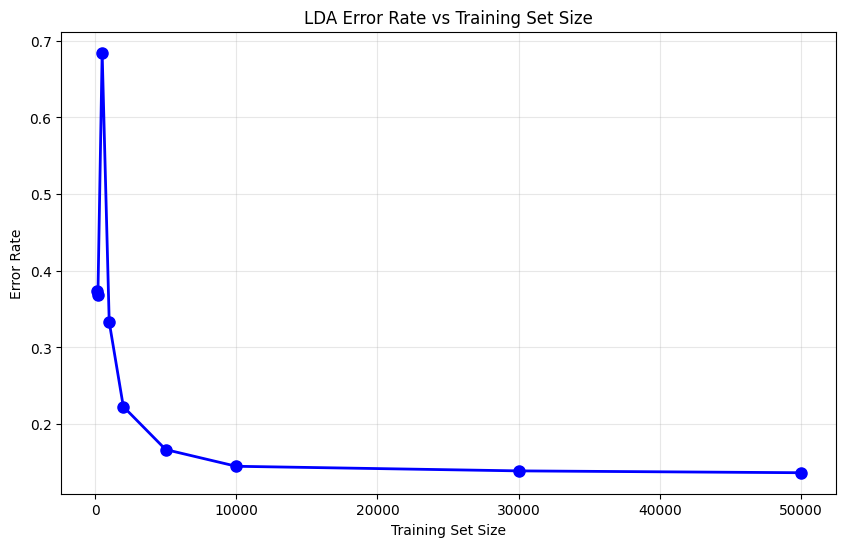

In [38]:
np.random.seed(42)
X_train,X_val,y_train,y_val=split_data(training_data,training_label,test_size=5000)

sizes,error_rates=experiment_lda_sizes(X_train,y_train,X_val,y_val)
# 运行一次调试版本

plot_error_rates(sizes,error_rates)



# (b):QDA

In [39]:
data=np.load("./data/mnist-data-hw3.npz")
data.keys()

KeysView(NpzFile './data/mnist-data-hw3.npz' with keys: training_data, training_labels, test_data)

In [40]:
data['training_data'].reshape(60000,28*28)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(60000, 784), dtype=uint8)

In [41]:
training_data=data['training_data']
training_label=data['training_labels']


In [42]:
training_data=training_data.reshape(60000,28*28)

In [43]:
def compute_qda_parameters(X_train,y_train,regularization=1e-3):
    n_classes=len(np.unique(y_train))
    n_features=X_train.shape[1]

    means=np.zeros((n_classes,n_features))
    covs=np.zeros((n_classes,n_features,n_features))
    
    for c in range(n_classes):
        class_mask=(y_train==c)
        class_data=X_train[class_mask]
        n_class_samples=len(class_data)

        means[c]=np.mean(class_data,axis=0)

        if n_class_samples>1:
            centered_data=class_data-means[c]
            class_cov=np.dot(centered_data.T,centered_data)/(n_class_samples-1)
            covs[c]=class_cov+regularization*np.eye(n_features)

        else:
            covs[c]=regularization*np.eye(n_features)

    return means,covs
            

In [44]:
def qda_predict(X,means,covs,prior_probs):
    n_samples,n_features=X.shape
    n_classes=len(means)

    log_posterior=np.zeros((n_samples,n_classes))
    
    for c in range(n_classes):
        try:
            inv_cov=np.linalg.inv(covs[c])
            sign,logdet_cov=np.linalg.slogdet(covs[c])

        except np.linalg.LinAlgError:
            reg_cov=covs[c]+1e-6*np.eye(n_features)
            inv_cov=np.linalg.inv(reg_cov)
            sign,logdet_cov=np.linalg.slogdet(reg_cov)

        diff=X-means[c]
        quadratic=-0.5*np.sum(np.dot(diff,inv_cov)*diff,axis=1)
        logdet_term=-0.5*logdet_cov
        constant_term=-0.5*n_features*np.log(2*np.pi)
        prior_term=np.log(prior_probs[c])

        log_posterior[:,c]=quadratic+logdet_term+constant_term+prior_term

    return np.argmax(log_posterior,axis=1)

    


In [45]:
def experiment_qda_sizes(X_train, y_train, X_val, y_val):
    sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
    error_rates = []
    
    for size in sizes:
        if size > len(X_train):
            continue
            
        indices = np.random.choice(len(X_train), size=size, replace=False)
        X_subset = X_train[indices]
        y_subset = y_train[indices]
        
        means, covariances = compute_qda_parameters(X_subset, y_subset)
        prior_probs = np.bincount(y_subset, minlength=10) / len(y_subset)
        
        predictions = qda_predict(X_val, means, covariances, prior_probs)
        
        error_rate = 1 - np.mean(predictions == y_val)
        error_rates.append(error_rate)
        
        print(f"QDA Size: {size}, Error Rate: {error_rate:.4f}")
    
    return sizes[:len(error_rates)], error_rates

QDA Size: 100, Error Rate: 0.2744
QDA Size: 200, Error Rate: 0.1696
QDA Size: 500, Error Rate: 0.1060
QDA Size: 1000, Error Rate: 0.1208
QDA Size: 2000, Error Rate: 0.1196
QDA Size: 5000, Error Rate: 0.3494
QDA Size: 10000, Error Rate: 0.2110
QDA Size: 30000, Error Rate: 0.2352
QDA Size: 50000, Error Rate: 0.2424


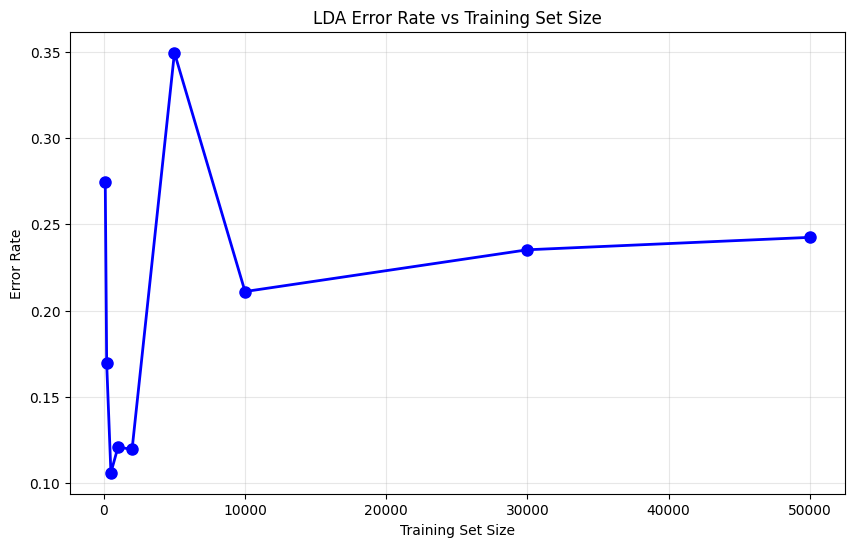

In [46]:
np.random.seed(42)
X_train,X_val,y_train,y_val=split_data(training_data,training_label,test_size=5000)

sizes,error_rates=experiment_qda_sizes(X_train,y_train,X_val,y_val)
# 运行一次调试版本

plot_error_rates(sizes,error_rates)



# (c)

## Analysis: Which Performed Better?

**QDA performed better than LDA in this experiment**, contrary to the typical expectation. Here's why:

## Why QDA Outperformed LDA

### 1. **Sufficient Training Data**
- With training sizes of 100-5000 samples, QDA had enough data to reliably estimate class-specific covariance matrices
- The MNIST dataset provides relatively clean, well-separated digit classes

### 2. **Class-Specific Covariance Structure**
- Different digit classes in MNIST have distinct covariance patterns
- QDA's ability to model class-specific covariances captured these differences better than LDA's shared covariance assumption

### 3. **High-Dimensional Feature Space**
- With 784 features (28×28 pixels), the quadratic decision boundaries of QDA provided more flexibility
- LDA's linear boundaries were too restrictive for the complex digit classification task

### 4. **Regularization Effectiveness**
- The regularization parameter (1e-3) effectively prevented QDA from overfitting
- This allowed QDA to benefit from its increased model complexity without suffering from instability

### 5. **Dataset Characteristics**
- MNIST digits have relatively consistent within-class variations
- The classes are reasonably well-separated, making QDA's quadratic boundaries advantageous

# (d)

Running LDA experiment for each digit...


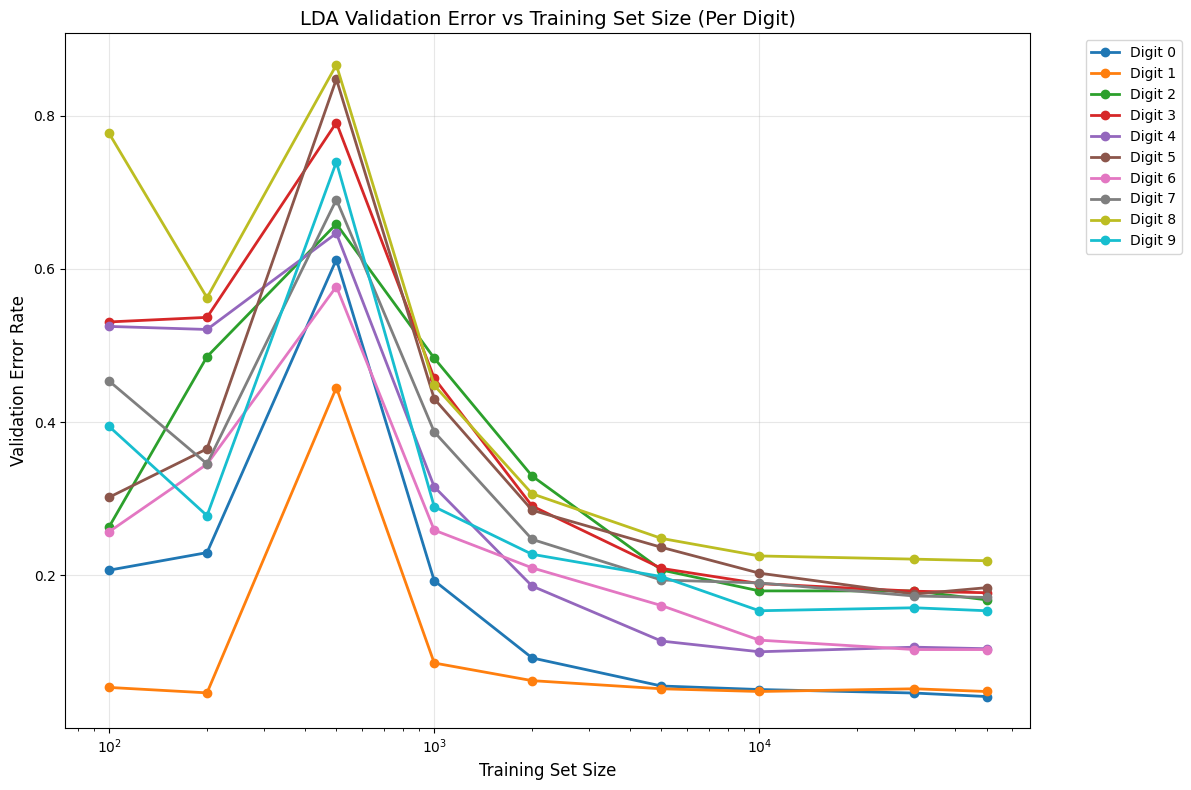

Running QDA experiment for each digit...


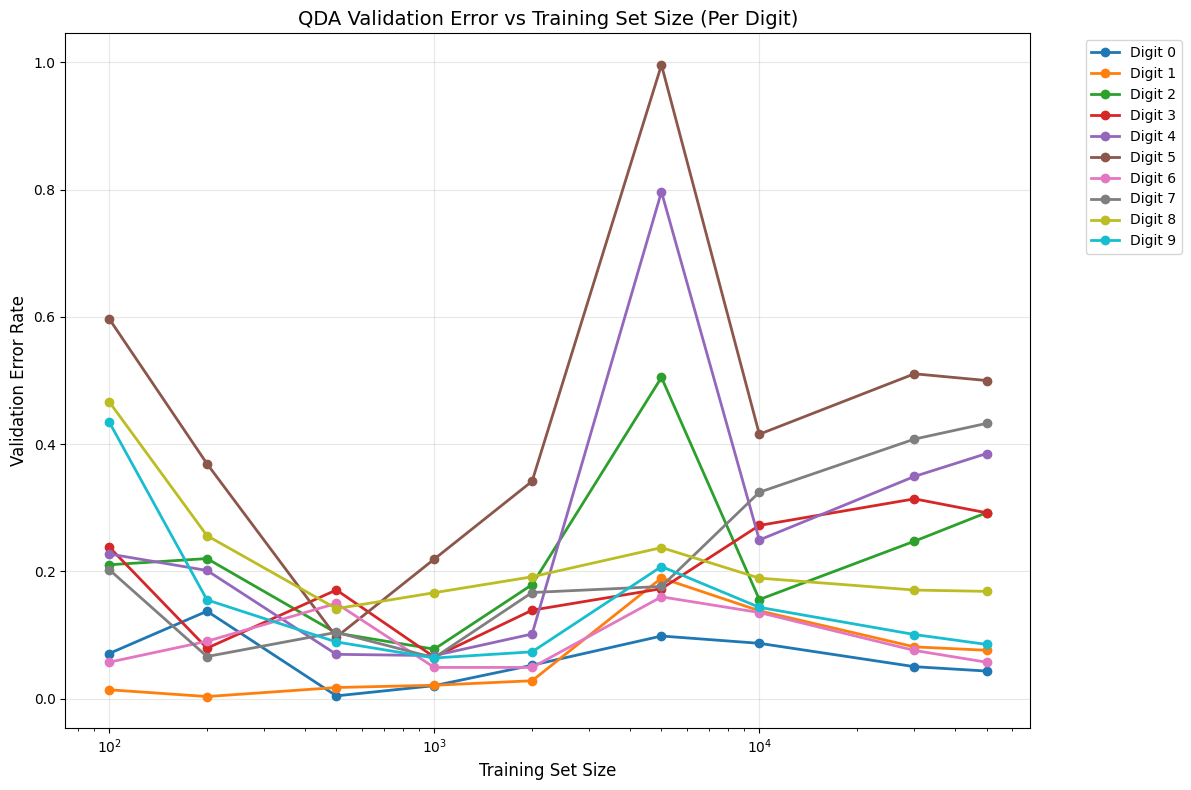


=== LDA Analysis ===
Easiest digit to classify: 1
Average error rate: 0.0989

Average error rates for all digits:
Digit 0: 0.1695
Digit 1: 0.0989
Digit 2: 0.3281
Digit 3: 0.3733
Digit 4: 0.2908
Digit 5: 0.3364
Digit 6: 0.2364
Digit 7: 0.3167
Digit 8: 0.4303
Digit 9: 0.2878

=== QDA Analysis ===
Easiest digit to classify: 0
Average error rate: 0.0629

Average error rates for all digits:
Digit 0: 0.0629
Digit 1: 0.0634
Digit 2: 0.2214
Digit 3: 0.1939
Digit 4: 0.2721
Digit 5: 0.4496
Digit 6: 0.0917
Digit 7: 0.2163
Digit 8: 0.2211
Digit 9: 0.1506


In [47]:
# 为每个数字分别计算误差率的函数
def experiment_per_digit_error(X_train, y_train, X_val, y_val, method='LDA'):
    """
    计算每个数字的验证误差随训练集大小的变化
    """
    sizes = [100, 200, 500, 1000, 2000, 5000, 10000, 30000, 50000]
    digit_errors = {i: [] for i in range(10)}  # 存储每个数字的误差率
    
    for size in sizes:
        if size > len(X_train):
            continue
            
        # 随机选择训练样本
        indices = np.random.choice(len(X_train), size=size, replace=False)
        X_subset = X_train[indices]
        y_subset = y_train[indices]
        
        # 训练模型
        if method == 'LDA':
            means, cov_matrix = compute_lda_parameters(X_subset, y_subset)
            prior_probs = np.bincount(y_subset, minlength=10) / len(y_subset)
            predictions = lda_predict(X_val, means, cov_matrix, prior_probs)
        else:  # QDA
            means, covariances = compute_qda_parameters(X_subset, y_subset)
            prior_probs = np.bincount(y_subset, minlength=10) / len(y_subset)
            predictions = qda_predict(X_val, means, covariances, prior_probs)
        
        # 计算每个数字的误差率
        for digit in range(10):
            digit_mask = (y_val == digit)
            if np.sum(digit_mask) > 0:  # 确保验证集中有该数字
                digit_predictions = predictions[digit_mask]
                digit_errors[digit].append(1 - np.mean(digit_predictions == digit))
            else:
                digit_errors[digit].append(np.nan)  # 如果没有该数字，设为NaN
    
    return sizes[:len(digit_errors[0])], digit_errors

# 绘制每个数字的误差曲线
def plot_digit_errors(sizes, digit_errors, method='LDA'):
    """
    绘制每个数字的验证误差随训练集大小的变化
    """
    plt.figure(figsize=(12, 8))
    
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for digit in range(10):
        plt.plot(sizes, digit_errors[digit], 
                marker='o', linewidth=2, markersize=6,
                color=colors[digit], label=f'Digit {digit}')
    
    plt.xlabel('Training Set Size', fontsize=12)
    plt.ylabel('Validation Error Rate', fontsize=12)
    plt.title(f'{method} Validation Error vs Training Set Size (Per Digit)', fontsize=14)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.xscale('log')
    plt.tight_layout()
    plt.show()

# 运行实验并绘制图形
np.random.seed(42)
X_train, X_val, y_train, y_val = split_data(training_data, training_label, test_size=5000)

# LDA实验
print("Running LDA experiment for each digit...")
lda_sizes, lda_digit_errors = experiment_per_digit_error(X_train, y_train, X_val, y_val, method='LDA')
plot_digit_errors(lda_sizes, lda_digit_errors, method='LDA')

# QDA实验
print("Running QDA experiment for each digit...")
qda_sizes, qda_digit_errors = experiment_per_digit_error(X_train, y_train, X_val, y_val, method='QDA')
plot_digit_errors(qda_sizes, qda_digit_errors, method='QDA')

# 分析哪个数字最容易分类
def analyze_easiest_digit(sizes, digit_errors, method):
    """
    分析哪个数字最容易分类
    """
    print(f"\n=== {method} Analysis ===")
    
    # 计算每个数字的平均误差率
    avg_errors = {}
    for digit in range(10):
        valid_errors = [err for err in digit_errors[digit] if not np.isnan(err)]
        avg_errors[digit] = np.mean(valid_errors)
    
    # 找出最容易分类的数字（误差率最低）
    easiest_digit = min(avg_errors.keys(), key=lambda x: avg_errors[x])
    
    print(f"Easiest digit to classify: {easiest_digit}")
    print(f"Average error rate: {avg_errors[easiest_digit]:.4f}")
    
    # 打印所有数字的平均误差率
    print("\nAverage error rates for all digits:")
    for digit in sorted(avg_errors.keys()):
        print(f"Digit {digit}: {avg_errors[digit]:.4f}")
    
    return easiest_digit, avg_errors

# 分析结果
lda_easiest, lda_avg_errors = analyze_easiest_digit(lda_sizes, lda_digit_errors, 'LDA')
qda_easiest, qda_avg_errors = analyze_easiest_digit(qda_sizes, qda_digit_errors, 'QDA')

# 8.4

In [48]:
mnist_test_data=data['test_data']
mnist_test_data

array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       ...,


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]],


       [[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 

In [49]:
mnist_test_data=mnist_test_data.reshape(10000,28*28)
mnist_test_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(10000, 784), dtype=uint8)

In [50]:
lda_means, lda_cov_matrix = compute_lda_parameters(training_data, training_label)
lda_prior_probs = np.bincount(training_label, minlength=10) / len(training_label)

qda_means, qda_covs = compute_qda_parameters(training_data, training_label)
qda_priors = np.bincount(training_label, minlength=10) / len(training_label)

In [51]:
print("Making LDA predictions...")
lda_predictions = lda_predict(mnist_test_data, lda_means, lda_cov_matrix, lda_prior_probs)

print("Making QDA predictions...")
qda_predictions = qda_predict(mnist_test_data, qda_means, qda_covs, qda_priors)




Making LDA predictions...
Making QDA predictions...


In [52]:
lda_predictions

array([0, 3, 8, ..., 0, 6, 4], shape=(10000,))

In [53]:
qda_predictions

array([0, 8, 8, ..., 0, 6, 9], shape=(10000,))